<a href="https://colab.research.google.com/github/guidomoor/FEA-ML/blob/main/Nonlinear_Elastic_D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Netowrk to predict D components, from strain states

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
class Model(nn.Module):
    def __init__(self, in_features=9, h1=64, h2=128, h3=64, out_features=9):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)

        self.out = nn.Linear(h3, out_features)
        #self.dropout = nn.Dropout(p=0.1)  # Reduce dropout to retain capacity

    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = self.dropout(x)
        x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = F.relu(self.fc3(x))
        #x = self.dropout(x)

        x = self.out(x)
        return x




In [4]:
torch.manual_seed(42)
model = Model()

In [5]:
from google.colab import files

# Upload a file
uploaded = files.upload()

# Check the uploaded files
for filename in uploaded.keys():
    print(f'Uploaded file: {filename}')
    my_df = pd.read_csv(filename, header=None)  # Read the CSV file into a DataFrame

Saving Collinear_EdEdSD_norm.csv to Collinear_EdEdSD_norm.csv
Uploaded file: Collinear_EdEdSD_norm.csv


In [6]:
# DF has 17 columns:
# INPUT: 3 strains (E)
# OUTPUT: 3x3 D components
X = my_df.iloc[:, :9]  # Select the first 3 columns, E
y = my_df.iloc[:, 9:]   # Select the last 3 columns, S
#convert to numpy arrays
#Data used in the NN
X = X.values
y = y.values

In [7]:
from sklearn.model_selection import train_test_split

# Combine inputs and outputs into a single array for proper splitting
data = np.hstack((X, y))

# Ensure data is unique
unique_data = np.unique(data, axis=0)

# Split the unique data into training and validation sets
train_data, val_data = train_test_split(unique_data, test_size=0.1, random_state=42)

# Separate inputs (X) and outputs (y) for training and validation
X_train, y_train = train_data[:, :9], train_data[:, 9:]
X_test, y_test = val_data[:, :9], val_data[:, 9:]



# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)


In [8]:
#Set the criterion of model to measure the error

criterion = nn.MSELoss()  # Use MSE loss for regression
#criterion = nn.HuberLoss(delta=0.05)  # More sensitive to small errors

#criterion = nn.L1Loss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-6,betas=(0.8, 0.999))
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, nesterov=True)


In [9]:
#Train the model:
# Epochs: (one run through all the training data in the network)
epochs = 15000
losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for i in range(epochs):
    model.train()
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.detach().numpy())

    # Calculate accuracy for training and validation
    with torch.no_grad():
        model.eval()
        train_accuracy = 1 - torch.mean(torch.abs(y_pred - y_train))
        val_pred = model(X_test)
        val_loss = criterion(val_pred, y_test)
        val_losses.append(val_loss.detach().numpy())
        val_accuracy = 1 - torch.mean(torch.abs(val_pred - y_test))
        train_accuracies.append(train_accuracy.item())
        val_accuracies.append(val_accuracy.item())

    # Print the losses (for tracking training progress)
    if i % 10 == 0:
        print(f"Epoch: {i} Loss: {loss}")

    # Backpropagation: update the model's weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0 Loss: 0.008312749676406384
Epoch: 10 Loss: 0.0035918469075113535
Epoch: 20 Loss: 0.0017988319741562009
Epoch: 30 Loss: 0.0017748789396137
Epoch: 40 Loss: 0.0016398988664150238
Epoch: 50 Loss: 0.0015857054386287928
Epoch: 60 Loss: 0.0015457798726856709
Epoch: 70 Loss: 0.0015038370620459318
Epoch: 80 Loss: 0.0014665425987914205
Epoch: 90 Loss: 0.001431093318387866
Epoch: 100 Loss: 0.0013973505701869726
Epoch: 110 Loss: 0.00136210722848773
Epoch: 120 Loss: 0.0013219787506386638
Epoch: 130 Loss: 0.0012708647409453988
Epoch: 140 Loss: 0.0012192782014608383
Epoch: 150 Loss: 0.0011614126851782203
Epoch: 160 Loss: 0.0010980147635564208
Epoch: 170 Loss: 0.001030424376949668
Epoch: 180 Loss: 0.000960123841650784
Epoch: 190 Loss: 0.0008924001012928784
Epoch: 200 Loss: 0.0008334430167451501
Epoch: 210 Loss: 0.0007841153419576585
Epoch: 220 Loss: 0.0007452015415765345
Epoch: 230 Loss: 0.0007154112681746483
Epoch: 240 Loss: 0.0006918431026861072
Epoch: 250 Loss: 0.0006726892897859216
Epoch:

Text(0.5, 0, 'Epoch')

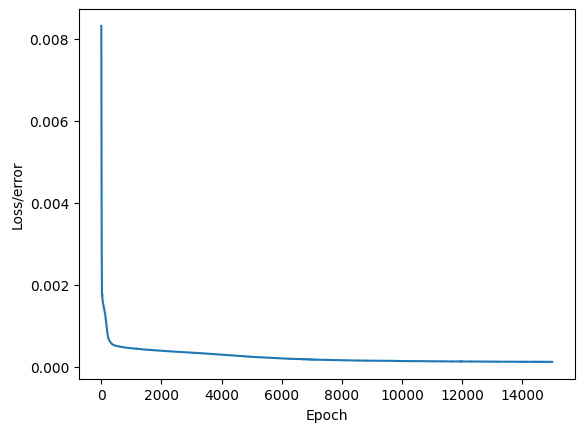

In [10]:
#Plot Loss
plt.plot(range(epochs), losses)
plt.ylabel('Loss/error')
plt.xlabel('Epoch')

In [11]:
# Set the model to evaluation mode
model.eval()

# Disable gradient calculation
with torch.no_grad():
    # Get predictions
    y_preds = model(X_test)

    # Calculate Mean Absolute Error (MAE)
    mae = torch.mean(torch.abs(y_preds - y_test))
    print(f'MAE: {mae.item():.4f}')

    # Calculate Mean Squared Error (MSE)
    mse = torch.mean((y_preds - y_test) ** 2)
    print(f'MSE: {mse.item():.4f}')

    # Calculate R-squared
    ss_total = torch.sum((y_test - torch.mean(y_test)) ** 2)
    ss_residual = torch.sum((y_test - y_preds) ** 2)
    r_squared = 1 - (ss_residual / ss_total)
    print(f'R-squared: {r_squared.item():.4f}')

MAE: 0.0038
MSE: 0.0002
R-squared: 0.9146


In [12]:
# Get final training and validation accuracy
final_train_accuracy = train_accuracies[-1]  # Last recorded training accuracy
final_val_accuracy = val_accuracies[-1]  # Last recorded validation accuracy

# Print final accuracy values
print(f'Final Training Accuracy: {final_train_accuracy * 100:.2f}%')
print(f'Final Validation Accuracy: {final_val_accuracy * 100:.2f}%')


Final Training Accuracy: 99.64%
Final Validation Accuracy: 99.62%


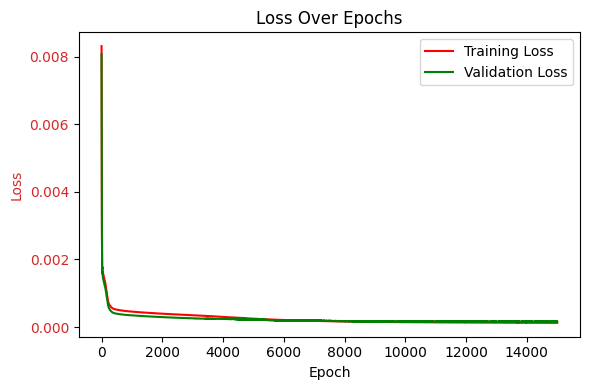

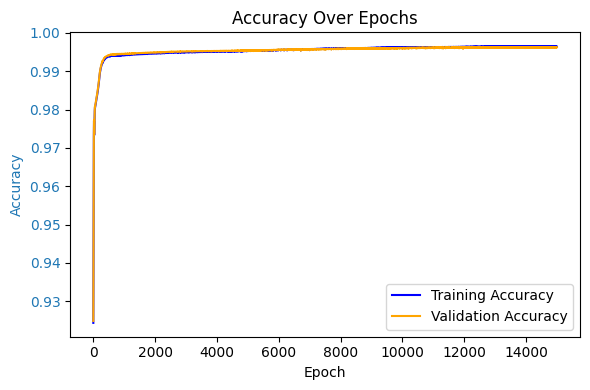

In [13]:
# Plot Loss
fig1, ax1 = plt.subplots(figsize=(6, 4))  # Create a rectangular figure for Loss
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(epochs), losses, label='Training Loss', color='red')
ax1.plot(range(epochs), val_losses, label='Validation Loss', color='green')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper right')
plt.title('Loss Over Epochs')
fig1.tight_layout()  # Adjust layout
plt.show()

# Plot Accuracy
fig2, ax2 = plt.subplots(figsize=(6, 4))  # Create a rectangular figure for Accuracy
color = 'tab:blue'
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(range(epochs), train_accuracies, label='Training Accuracy', color='blue')
ax2.plot(range(epochs), val_accuracies, label='Validation Accuracy', color='orange')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='lower right')
plt.title('Accuracy Over Epochs')
fig2.tight_layout()  # Adjust layout
plt.show()


In [14]:
ew_input = torch.tensor([[-0.000300000,	-0.00030000,	-0.001600,	-0.00080000,	-0.00080000,	-0.004600000,	-0.0042000,	-0.004200,	-0.004200000]])

print(f"Selected Input: {ew_input.numpy()}\n")

# **Perform Forward Pass and Print Activations**
with torch.no_grad():
    # Ensure the model is in evaluation mode
    model.eval()

    # Initialize a counter for layers
    layer_num = 1

    # ----------------- Layer 1 (fc1) -----------------
    layer1_output = model.fc1(ew_input)  # Linear transformation
    activ1 = F.relu(layer1_output)       # Activation
    print(f"Layer: {layer_num}")
    for neuron_num, activation in enumerate(activ1[0], start=1):
        print(f" Neuron: {neuron_num} Activation: {activation.item():.12f}")
    layer_num += 1

    # ----------------- Layer 2 (fc2) -----------------
    layer2_input = activ1
    layer2_output = model.fc2(layer2_input)
    activ2 = F.relu(layer2_output)
    print(f"Layer: {layer_num}")
    for neuron_num, activation in enumerate(activ2[0], start=1):
        print(f" Neuron: {neuron_num} Activation: {activation.item():.12f}")
    layer_num += 1

    # ----------------- Layer 3 (fc3) -----------------
    layer3_input = activ2
    layer3_output = model.fc3(layer3_input)
    activ3 = F.relu(layer3_output)
    print(f"Layer: {layer_num}")
    for neuron_num, activation in enumerate(activ3[0], start=1):
        print(f" Neuron: {neuron_num} Activation: {activation.item():.12f}")
    layer_num += 1

    # ----------------- Output Layer (out) -----------------
    output_input = activ3
    output = model.out(output_input)
    # Assuming no activation function on output layer
    print(f"Layer: {layer_num}")
    for neuron_num, activation in enumerate(output[0], start=1):
        print(f" Neuron: {neuron_num} Activation: {activation.item():.12f}")

    # Optionally, print the final output
    print(f"\nFinal Output: {output.numpy()}")

Selected Input: [[-0.0003 -0.0003 -0.0016 -0.0008 -0.0008 -0.0046 -0.0042 -0.0042 -0.0042]]

Layer: 1
 Neuron: 1 Activation: 0.000000000000
 Neuron: 2 Activation: 0.180667728186
 Neuron: 3 Activation: 0.000000000000
 Neuron: 4 Activation: 0.000000000000
 Neuron: 5 Activation: 0.197187617421
 Neuron: 6 Activation: 0.000000000000
 Neuron: 7 Activation: 0.035176075995
 Neuron: 8 Activation: 0.287611365318
 Neuron: 9 Activation: 0.000000000000
 Neuron: 10 Activation: 0.101402841508
 Neuron: 11 Activation: 0.000000000000
 Neuron: 12 Activation: 0.033162962645
 Neuron: 13 Activation: 0.007491002791
 Neuron: 14 Activation: 0.091436028481
 Neuron: 15 Activation: 0.137438118458
 Neuron: 16 Activation: 0.274472385645
 Neuron: 17 Activation: 0.000000000000
 Neuron: 18 Activation: 0.000000000000
 Neuron: 19 Activation: 0.000000000000
 Neuron: 20 Activation: 0.000000000000
 Neuron: 21 Activation: 0.000000000000
 Neuron: 22 Activation: 0.000000000000
 Neuron: 23 Activation: 0.219740301371
 Neuron: 2

In [15]:


# Set full-precision print options
torch.set_printoptions(precision=16, sci_mode=False)

# Define the new input tensor with **double precision**
new_input = torch.tensor([[-0.0129987652441603,	-0.0129987652441603,	-0.0596361698888720,	-0.00112904044248237,	-0.00112904044248237,	-0.00630909490705502,	-0.00577531101671429,	-0.00577531101671429,	-0.00577532680346001]],
                         dtype=torch.float64)  # Ensure full precision


input_maxS = 1963.67260
input_maxE = 0.23648453

output_max = 214502.392343652

# Normalize the new input (Corrected for potential min values)
new_input_normalized = (new_input)

# Print full-precision values
print(f'Raw Input (Full Precision): {new_input}')
#print(f'Normalized Input (Full Precision): {new_input_normalized}')

# Ensure model weights use float64 if needed
model = model.to(torch.float64)  # If model was trained with float64

# Disable gradient calculation
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode

    # Perform prediction on normalized input
    y_pred = model(new_input)

    # Denormalize the prediction to get the real-world values
    y_pred_real = y_pred * output_max
    #x_input_real = new_input * input_max

    # Print the denormalized prediction
    #print(f'Denormalized Prediction (Full Precision): {y_pred_real}')
    print(f'Normalized Prediction (Full Precision): {y_pred}')

    print(f'Denormalized Prediction (Full Precision): {y_pred_real}')


Raw Input (Full Precision): tensor([[-0.0129987652441603, -0.0129987652441603, -0.0596361698888720,
         -0.0011290404424824, -0.0011290404424824, -0.0063090949070550,
         -0.0057753110167143, -0.0057753110167143, -0.0057753268034600]],
       dtype=torch.float64)
Normalized Prediction (Full Precision): tensor([[ 0.0557671199471327,  0.0221341676141540, -0.0009674185928621,
          0.0267379911321310,  0.0530040376081890, -0.0004452262061834,
         -0.0010778202525882, -0.0007537783562198,  0.0150431912340138]],
       dtype=torch.float64)
Denormalized Prediction (Full Precision): tensor([[11962.1806427753563185,  4747.8319057714088558,  -207.5136025666396620,
          5735.3630643054557368, 11369.4928708294373791,   -95.5020863604341059,
          -231.1950226966164621,  -161.6872607060089422,  3226.8005081790047370]],
       dtype=torch.float64)


In [16]:
# Access weights directly from each layer
weights_fc1 = model.fc1.weight.data.numpy()
weights_fc2 = model.fc2.weight.data.numpy()
weights_fc3 = model.fc3.weight.data.numpy()
weights_out = model.out.weight.data.numpy()

print("Weights from fc1:", weights_fc1)
print("Weights from fc2:", weights_fc2)
print("Weights from fc3:", weights_fc3)
print("Weights from output layer:", weights_out)

# Function to save weights with a maximum of 8 values per row
def save_weights_with_comma_format(file_name, weights):
    reshaped_weights = weights.reshape(-1, 8)  # Reshape to have at most 8 columns
    with open(file_name, 'w') as f:
        for row in reshaped_weights:
            # Convert each row to a string with comma separation
            f.write(','.join(f'{x:.9f}' for x in row) + ',\n')

# Save weights to text files with the modified formatting
save_weights_with_comma_format('weights_fc1.txt', weights_fc1)
save_weights_with_comma_format('weights_fc2.txt', weights_fc2)
save_weights_with_comma_format('weights_fc3.txt', weights_fc3)
save_weights_with_comma_format('weights_output.txt', weights_out)

Weights from fc1: [[ 5.52339017e-01  1.70413959e+00  4.41089779e-01  4.57912356e-01
   3.10281038e-01 -1.09785937e-01  4.45433080e-01  4.36254777e-02
   4.32079919e-02]
 [-2.51947045e-01  1.10139740e+00 -2.77841892e-02  1.08820908e-01
   4.21816111e-02  7.22347498e-02 -2.72194892e-01  1.12230897e+00
   1.41853169e-01]
 [-1.44349709e-01  7.88191259e-02 -1.42471701e-01 -3.62637229e-02
  -1.25597492e-01  2.05127120e-01 -2.44089931e-01 -1.42555907e-01
  -8.73144940e-02]
 [-3.56055111e-01 -1.69415399e-02 -7.03281641e-01  4.99713629e-01
  -6.37877464e-01  6.29285395e-01  1.28154874e-01  3.29881199e-02
   3.61307561e-01]
 [-7.52212405e-02  5.35225391e-01 -1.45801172e-01 -2.64595956e-01
  -1.92601168e+00 -2.09455192e-01  9.03310701e-02  1.14660645e+00
   1.95779026e-01]
 [-1.35175928e-01  1.78502768e-01  5.53264879e-02  1.57030284e-01
  -1.88468382e-01 -3.06096196e-01 -1.19470999e-01 -2.37175122e-01
   2.53715813e-01]
 [-1.80515256e-02  5.16365051e-01  9.82677877e-01  5.08572817e-01
   2.50037

In [17]:
# Function to save the biases with commas, including at the end of the row
def save_biases_with_comma_format(file_name, biases):
    # Calculate the padding required to make the length a multiple of 8
    padding_length = (8 - (biases.size % 8)) % 8
    padded_biases = np.pad(biases, (0, padding_length), mode='constant', constant_values=0)

    # Reshape the padded array to have at most 8 columns per row
    reshaped_biases = padded_biases.reshape(-1, 8)

    with open(file_name, 'w') as f:
        for row in reshaped_biases:
            # Convert each row to a string with comma separation and add a comma at the end
            f.write(','.join(f'{x:.8f}' for x in row) + ',\n')

# Access biases directly from each layer
bias_fc1 = model.fc1.bias.data.numpy()
bias_fc2 = model.fc2.bias.data.numpy()
bias_fc3 = model.fc3.bias.data.numpy()
bias_out = model.out.bias.data.numpy()

print("Biases from fc1:", bias_fc1)
print("Biases from fc2:", bias_fc2)
print("Biases from fc3:", bias_fc3)
print("Biases from output layer:", bias_out)

# Save biases to text files with the modified formatting
save_biases_with_comma_format('Biases1.txt', bias_fc1)
save_biases_with_comma_format('Biases2.txt', bias_fc2)
save_biases_with_comma_format('Biases3.txt', bias_fc3)
save_biases_with_comma_format('BiasesOut.txt', bias_out)

Biases from fc1: [ 1.23959605e-03  1.85497448e-01 -1.52558684e-01 -1.31002620e-01
  2.00393766e-01 -2.69420236e-01  3.36473994e-02  2.90480465e-01
  3.59862042e-03  9.90563855e-02 -7.89550878e-03  1.11823073e-02
  7.01155281e-03  8.72019827e-02  1.30127400e-01  2.72270590e-01
 -2.36027926e-01 -1.87987322e-03 -2.76433700e-03 -2.44615987e-01
 -2.39770219e-04 -2.72184908e-01  2.18365073e-01  6.81953654e-02
 -1.66658223e-01  1.71365619e-01 -2.92650729e-01  9.38300946e-05
  1.54359397e-04 -2.62766838e-01 -1.96628362e-01  2.14238808e-05
  2.41656750e-01  2.96693623e-01  2.09811628e-01 -1.84641302e-01
 -2.56450218e-03  2.65748471e-01  1.01080723e-01 -2.02392712e-05
  5.81642985e-02 -2.48513222e-01  1.71685184e-03  2.89482951e-01
  2.60245800e-03  9.36985452e-05 -2.56767005e-01 -1.72980696e-01
 -4.27330937e-03 -8.72059017e-02  1.78526994e-03  1.17855869e-01
 -3.02470177e-01  1.25313580e-01 -4.92231222e-03 -1.50914386e-01
  1.13938376e-01  2.28773087e-01 -8.45117494e-02 -1.26951277e-01
 -1.2058

<Axes: >

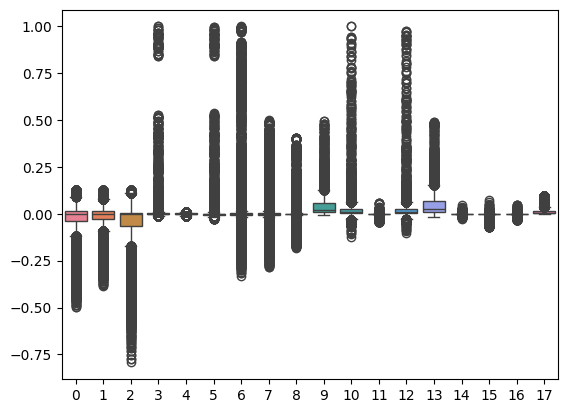

In [18]:
import seaborn as sns
sns.boxplot(data=my_df)


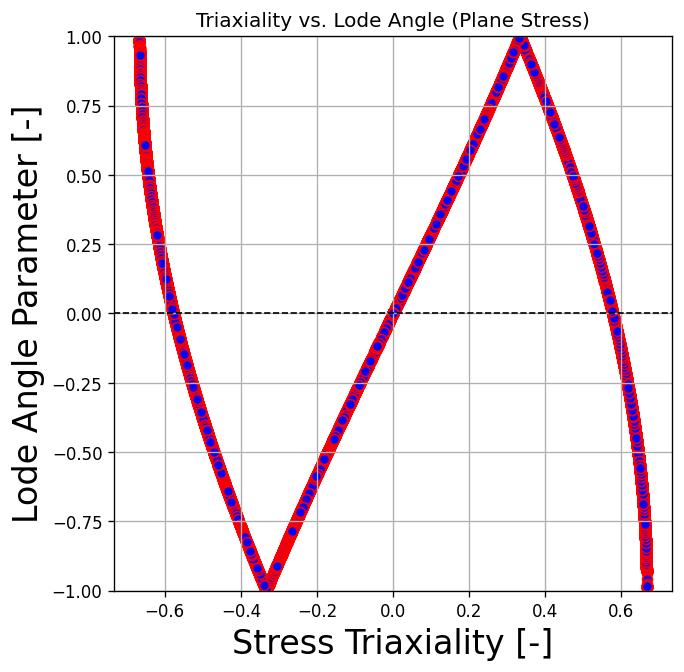

In [61]:
import numpy as np

def plane_stress_triaxiality_and_lode(sigma_xx, sigma_yy, tau_xy):
    # Mean (hydrostatic) stress
    sigma_m = (sigma_xx + sigma_yy) / 3.0

    # von Mises equivalent stress
    sigma_eq = np.sqrt(sigma_xx**2 - sigma_xx*sigma_yy + sigma_yy**2 + 3.0*(tau_xy**2))

    # Stress triaxiality (avoid divide-by-zero if sigma_eq=0)
    if sigma_eq == 0:
        triax = 0.0
    else:
        triax = sigma_m / sigma_eq

    # Deviatoric components
    s_xx = sigma_xx - sigma_m
    s_yy = sigma_yy - sigma_m
    s_zz = -sigma_m
    s_xy = tau_xy

    # Third invariant of deviatoric stress
    J3 = s_zz * (s_xx*s_yy - s_xy**2)

    # Normalized third invariant
    # Add a small epsilon to avoid 0 in denominator
    eps = 1e-15
    xi = (27.0/2.0) * (J3 / ((sigma_eq**3) + eps))

    # Clip xi to [-1,1] for arccos
    xi = np.clip(xi, -1.0, 1.0)

    # Lode angle parameter
    lode_angle = 1.0 - (2.0/np.pi)*np.arccos(xi)

    return triax, lode_angle

# Extract sigma_xx, sigma_yy, tau_xy from DataFrame
sigma_xx = my_df.iloc[:, 6].values  # column 7 in 1-based indexing
sigma_yy = my_df.iloc[:, 7].values  # column 8
tau_xy   = my_df.iloc[:, 8].values  # column 9

triax_list = []
lode_list  = []

# Compute triaxiality & Lode angle for each row
for sx, sy, txy in zip(sigma_xx, sigma_yy, tau_xy):
    tri_val, lode_val = plane_stress_triaxiality_and_lode(sx, sy, txy)
    triax_list.append(tri_val)
    lode_list.append(lode_val)

plt.figure(figsize=(6, 6))  # Square figure
plt.scatter(triax_list, lode_list, c='blue', alpha=0.9, edgecolors='r')
plt.xlabel('Stress Triaxiality [-]', fontsize=20)
plt.ylabel('Lode Angle Parameter [-]', fontsize=20)
plt.title('Triaxiality vs. Lode Angle (Plane Stress)')
plt.grid(True)
# Add a horizontal dashed line at y=0
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.ylim(-1, 1)
plt.show()


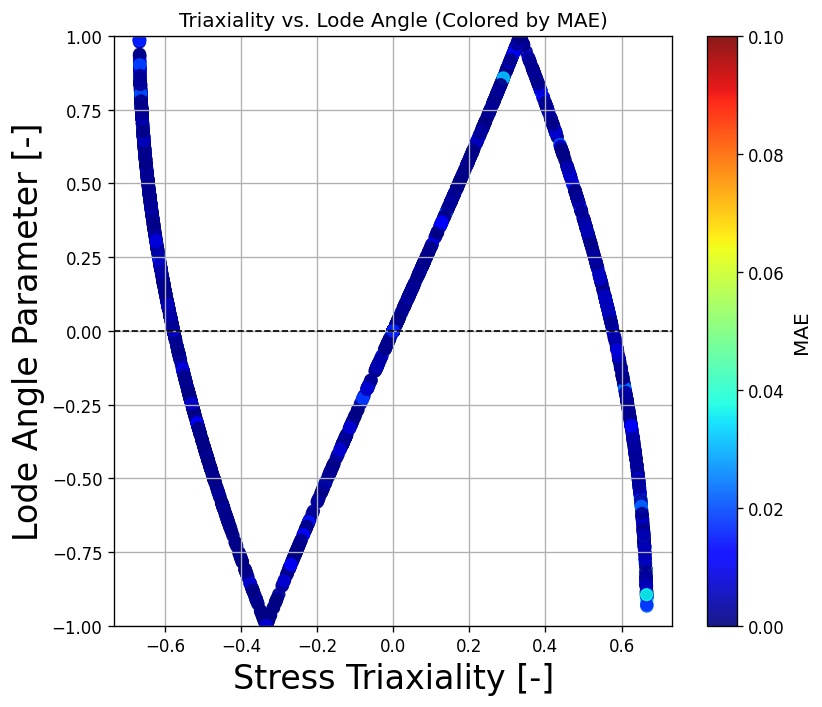

In [60]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

with torch.no_grad():
    model.eval()
    # Temporarily cast to float64 for evaluation (matching your model precision)
    X_test_double = X_test.to(torch.float64)
    y_test_double = y_test.to(torch.float64)

    # Get predictions and compute MAE per sample (averaged across outputs)
    y_pred_test = model(X_test_double)
    errors = torch.mean(torch.abs(y_pred_test - y_test_double), dim=1).cpu().numpy()

# Extract sigma_xx, sigma_yy, tau_xy from X_test_double
sigma_xx_test = X_test_double[:, 6].cpu().numpy()
sigma_yy_test = X_test_double[:, 7].cpu().numpy()
tau_xy_test   = X_test_double[:, 8].cpu().numpy()

# Compute triaxiality & lode angle
triax_test = []
lode_test  = []
for sx, sy, txy in zip(sigma_xx_test, sigma_yy_test, tau_xy_test):
    tri_val, lode_val = plane_stress_triaxiality_and_lode(sx, sy, txy)
    triax_test.append(tri_val)
    lode_test.append(lode_val)

# Create a figure with a colorbar for MAE
#plt.figure(figsize=(4.5, 4.0))  # Adjust figure size to your preference

plt.figure(figsize=(7, 6))  # Square figure
sc = plt.scatter(
    triax_test,
    lode_test,
    c=errors,
    cmap='jet',      # Blue-to-red colormap
    s=50,            # Marker size
    alpha=0.9,       # Transparency  # Black edges for better visibility
    vmin=0.0,        # Lower bound for colorbar
    vmax=0.1         # Upper bound for colorbar
)

# Add a colorbar from 0 to 0.1
cbar = plt.colorbar(sc)
cbar.set_label('MAE', fontsize=12)

# Labeling and styling
plt.xlabel('Stress Triaxiality [-]', fontsize=20)
plt.ylabel('Lode Angle Parameter [-]', fontsize=20)
plt.title('Triaxiality vs. Lode Angle (Colored by MAE)', fontsize=12)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.ylim(-1, 1)
plt.grid(True)


plt.tight_layout()
plt.show()

In [58]:
import plotly.express as px

# If your model is in float64, ensure X_test is also float64
X_test_double = X_test.to(torch.float64)
y_test_double = y_test.to(torch.float64)

with torch.no_grad():
    model.eval()
    y_pred_test = model(X_test_double)
    # Compute per-sample MAE (averaged over outputs)
    errors = torch.mean(torch.abs(y_pred_test - y_test_double), dim=1).cpu().numpy()

# Extract strain components from columns 0, 1, and 2 (E11, E22, E12)
E11 = X_test_double[:, 0].cpu().numpy()
E22 = X_test_double[:, 1].cpu().numpy()
E12 = X_test_double[:, 2].cpu().numpy()

# Create an interactive 3D scatter plot with Plotly
fig = px.scatter_3d(
    x=E11,
    y=E22,
    z=E12,
    color=errors,                     # Color represents MAE
    color_continuous_scale='jet',     # "jet" colormap
    title='Interactive 3D Plot: Strain vs. MAE'
)

# Customize layout to mimic a formal MATLAB-like view with equal axis lengths
fig.update_layout(
    template='plotly_white',
    scene=dict(
        xaxis=dict(
            title='E11',
            backgroundcolor='white',
            gridcolor='lightgrey',
            zerolinecolor='lightgrey',
            showbackground=True
        ),
        yaxis=dict(
            title='E22',
            backgroundcolor='white',
            gridcolor='lightgrey',
            zerolinecolor='lightgrey',
            showbackground=True
        ),
        zaxis=dict(
            title='E12',
            backgroundcolor='white',
            gridcolor='lightgrey',
            zerolinecolor='lightgrey',
            showbackground=True
        ),
        camera=dict(
            eye=dict(x=1.25, y=1.25, z=1.25)  # Isometric-like view
        ),
        aspectmode='cube'  # Ensures equal scaling on all axes
    ),
    coloraxis_colorbar=dict(
        title='MAE',
        tickfont=dict(size=12),
        titlefont=dict(size=14)
    )
)

fig.show()
